### Aggregation of Mutation Enrichment Across POGO Cycles

This notebook processes **precomputed variant enrichment tables** for each NGS run, organized by **POGO cycle**, **barcode**, and **section**.

To generate these enrichment tables, first run the pipeline `1_Illumina_analyze_mutation_enrichment.py`, which outputs:
- Enrichment scores per variant
- One CSV file per barcode/section combination

For more details, see the `README.md` file in this repository.

---

#### This notebook includes the following steps:
- Initialization of empty mutation enrichment matrices (AA × Position)  
- Iteration over all NGS runs and barcodes  
- Loading of enrichment CSVs from disk  
- Mapping enrichments to the appropriate POGO cycle  
- Accumulation of mutation data into final summary matrices  

---

### Notebook Setup

In [ ]:
# --- Import necessary modules ---
import os
import sys
os.chdir("..")
import json
import matplotlib.ticker as mticker
from Bio.SeqIO import QualityIO
import numpy as np
from utils import dna_rev_comp, translate_dna2aa
import pandas as pd
from scripts.functions_ import *
from scripts.plotting import *
from Bio import SeqIO
from Bio.Seq import Seq
from scripts.Illumina_functions import *
from scripts.linker_analysis_functions import *
from collections import Counter
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors
import matplotlib.colorbar as mcolorbar 
import matplotlib.pyplot as plt
import matplotlib as mpl

# ======================== PLOTTING SETTINGS ========================

# --- General matplotlib settings ---
fs = 8  # font size
plt.rcParams['svg.fonttype'] = 'none'
mpl.rcParams.update({
    'font.family': 'Avenir Next',
    'font.weight': 'demi', 
    'font.size': fs,
    'text.color': '#231F20',
    'axes.labelcolor': '#231F20',
    'xtick.color': '#231F20',
    'ytick.color': '#231F20',
    'axes.edgecolor': '#231F20',
    'figure.facecolor': 'white',
    'axes.facecolor': 'white',
    'pdf.fonttype': 42,
    'text.usetex': False
})
sns.set_context("paper", rc={
    "font.size": fs,
    "axes.titlesize": fs + 1,
    "axes.labelsize": fs,
    "axes.linewidth": 1,
    "xtick.labelsize": fs,
    "ytick.labelsize": fs,
    "legend.fontsize": fs,
    "legend.title_fontsize": fs + 1
})


# --- Custom color map for mutation visualization ---
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", [
    "#22577A",  # Deep blue
    "#38A3A5",  # Teal
    "#57CC99",  # Medium green
    "#80ED99",  # Bright green
    "#C7F9CC"   # Light pastel green
] , N=256)

# --- Seaborn theme configuration ---
custom_params = {"axes.spines.right": False, "axes.spines.top": False,'axes.linewidth':1}
sns.set_theme(context="paper",
              style='ticks',
              palette="Greys_r",rc=custom_params
             )


# ======================== LAYOUT PARAMETERS ========================

# --- Pre-defined figure dimensions for multi-panel plots ---

lw = 1
lw = 1
fs = 7
hi = 10.5 *0.75 # 6.69291
wi3 = 2.24 # 7.08661
wi2 = 4.76
wi1 = 7.24
nr = 5

(wi2, hi/2)

# --- Utility for shortening sample names ---
short_fn = np.vectorize(lambda x: x[:5])

### Load and organize amplicon data

In [2]:
amplicon_AraCLOV2 = 'CGCCGCATGGAAGCGATTAACGAAAGCAGCGGTTTAGCCACAACGCTGGAACGCATTGAAAAGAATTTCGTAATCACAGACCCGCGCCTTCCCGACAATCCAATTATTTTTGCGTCCGATAGCTTCCTGCAATTAACCGAATACAGCCGCGAAGAAATTCTGGGTCGTAATTGTCGCTTCCTTCAGGGGCCAGAGACTGACCGTGCTACGGTACGCAAAATCCGCGACGCAATCGACAATCAAACGGAAGTCACGGTTCAGTTGATTAACTATACGAAGAGCGGAAAAAAATTCTGGAATTTATTTCACTTGCAGCCTATGCGTGACCAGAAGGGCGATGTCCAGTATTTCATTGGCGTTCAGCTTGATGGTACCGAGCATGTTCGCGATGCTGCGGAGCGTGAAGGTGTAATGTTAATTAAAAAGACTGCTGAAAACATTGATGAGGCGGCCAAAGGGAGCCTGCATCCGCCGATGGATAACCGCGTG'
# --- Sequence region of interest ---
start_LOV2  = "ttagccacaa".upper() 
end_LOV2 = "cggccaaa".upper() 

LOV2_gene = amplicon_AraCLOV2[amplicon_AraCLOV2.index(start_LOV2):amplicon_AraCLOV2.index(end_LOV2)+len(end_LOV2)]

# --- Codons used for retron library (RL8) construction ---
ecoli_pref = { 
            "A": 'GCG',
            "R": 'CGT',
            "N": 'AAC',
            "D": 'GAT',
            "C": 'TGC',
            "Q": 'CAG',
            "E": 'GAA',
            "G": 'GGC',
            "H": 'CAT',
            "I": 'ATT',
            "L": "CTG",
            "K": 'AAA',
            "M": 'ATG',
            "F": "TTT",
            "P": 'CCG',
            "S": 'AGC',
            "T": 'ACC',
            "W": 'TGG',
            "Y": "TAT",
            "V": 'GTG',
}

genetic_code = {
  'ATA': 'I', 'ATC': 'I', 'ATT': 'I', 'ATG': 'M',
  'ACA': 'T', 'ACC': 'T', 'ACG': 'T', 'ACT': 'T',
  'AAC': 'N', 'AAT': 'N', 'AAA': 'K', 'AAG': 'K',
  'AGC': 'S', 'AGT': 'S', 'AGA': 'R', 'AGG': 'R',
  'CTA': 'L', 'CTC': 'L', 'CTG': 'L', 'CTT': 'L',
  'CCA': 'P', 'CCC': 'P', 'CCG': 'P', 'CCT': 'P',
  'CAC': 'H', 'CAT': 'H', 'CAA': 'Q', 'CAG': 'Q',
  'CGA': 'R', 'CGC': 'R', 'CGG': 'R', 'CGT': 'R',
  'GTA': 'V', 'GTC': 'V', 'GTG': 'V', 'GTT': 'V',
  'GCA': 'A', 'GCC': 'A', 'GCG': 'A', 'GCT': 'A',
  'GAC': 'D', 'GAT': 'D', 'GAA': 'E', 'GAG': 'E',
  'GGA': 'G', 'GGC': 'G', 'GGG': 'G', 'GGT': 'G',
  'TCA': 'S', 'TCC': 'S', 'TCG': 'S', 'TCT': 'S',
  'TTC': 'F', 'TTT': 'F', 'TTA': 'L', 'TTG': 'L',
  'TAC': 'Y', 'TAT': 'Y', 'TAA': '*', 'TAG': '*',
  'TGC': 'C', 'TGT': 'C', 'TGA': '*', 'TGG': 'W',
}

codons = list(genetic_code.keys())

# --- Get enrichment data ---

Folder = "final_output/RL8/combined/enrichments/Codons/" 

enrichment = pd.read_csv(f"{Folder}/RL8_BC1_S1_combined_roiTrue_Codons_enrichment_relative.csv", index_col = 0)

In [4]:
# --- Identify columns in the enrichment matrix that contain only NaN values ---
empty_cols = enrichment.columns[enrichment.isna().all()]

# --- Detect the column (position) with the highest total enrichment ---
max_col = enrichment.sum().idxmax()
# --- Mask the most enriched column (likely a silent mutation fixed in all phages) ---
enrichment[max_col] = np.nan 

# --- Replace all remaining NaN values with 0 for downstream calculations ---
enrichment.fillna(0, inplace=True)

# --- Set reference sequence for spectrum analysis (codon-level) ---
ref = LOV2_gene

### Calculate mutational spectrum

In [ ]:
# --- Calculate mutational spectrum from enrichment data ---
#     - Returns: absolute and percentage frequencies of codon mutations
mut_spectrum_codons,mut_spectrum_codons_perc = calc_mut_spectrum_from_enrichment(enrichment, ref_seq=ref, data_type="Codons")

In [ ]:
# ======================== FILTERING AND FORMATTING MUTAGENIC SPECTRUM ========================

# --- Compute nucleotide-based reference length (3 nt per codon) ---
ref_len = len(enrichment.columns) * 3 ## Nts instead of codons

# --- Adjust length to include 5′ region (AraC before LOV2 start) ---
ref_len = ref_len + amplicon_AraCLOV2.index(start_LOV2) 

# --- Generate codon-level reference sequence from AraC-LOV2 amplicon ---
ref_codons = [amplicon_AraCLOV2[i:i+3] for i in range(0,ref_len, 3)]

# --- Remove codons at positions with low coverage (i.e., excluded from enrichment) ---
ref_codons = [codon for idx, codon in enumerate(ref_codons) if str(idx) not in empty_cols]

# --- Retrieve sorted list of E. coli preferred codons ---
pref_codons = sorted(ecoli_pref.values())

# --- Reorder mutagenic spectrum: preferred codons first, then others ---
mut_spec_perc_ordered = pd.concat((mut_spectrum_codons_perc.loc[:,pref_codons], mut_spectrum_codons_perc.loc[:,[codon for codon in codons if codon not in pref_codons]]),axis = 1)
# --- Filter rows to only include codons found in reference ---
mut_spec_perc_ordered = mut_spec_perc_ordered.loc[[codon for codon in codons if codon in ref_codons],:] 
# --- Sort codon rows alphabetically ---
mut_spec_perc_ordered = mut_spec_perc_ordered.reindex(sorted(mut_spec_perc_ordered.index), axis=0) 


# ======================== ANNOTATION OF A ARAC-SPECIFIC CODONS ========================

# --- Find index where LOV2 begins in AraC-LOV2 reference sequence ---
LOVstart = amplicon_AraCLOV2.index(start_LOV2)
# --- Get AraC-only codons (upstream of LOV2) ---
AraC_codons = [amplicon_AraCLOV2[i:i+3] for i in range(0, LOVstart, 3)]
# --- Get LOV2 codons (targeted region) ---
LOV_codons = [amplicon_AraCLOV2[i:i+3] for i in range(LOVstart, ref_len, 3)]
# --- Identify codons unique to AraC (not found in LOV2 region) ---
AraC_spec_codons = [codon for codon in AraC_codons if codon not in LOV_codons]

# --- Count codon occurrences in the LOV2 region for row annotation ---
counter_LOV = Counter(LOV_codons)
# --- Ensure all codons in mutational spectrum are represented in the counter ---
for codon in mut_spec_perc_ordered.index:
    if codon not in counter_LOV:
        counter_LOV[codon] = 0
   
# --- Sort codon counter alphabetically by codon ---
counter_LOV = dict(sorted(counter_LOV.items()))

# --- Generate column annotations: 0 = preferred codon, 1 = non-preferred ---
col_annot = [0 if codon in pref_codons else 1 for codon in mut_spec_perc_ordered.columns]
# --- Get row annotation values from codon usage in LOV2 ---
row_annots = list(counter_LOV.values())


# --- Convert row annotation values into colormap colors (for plotting) ---
row_cmap = plt.get_cmap('Greys').reversed()
colors = ["darkgrey", "lightgrey"]
col_cmap = mcolors.LinearSegmentedColormap.from_list("custom_green_blue", colors, N=256)

norm = plt.Normalize(min(row_annots), max(row_annots))
row_annot = [row_cmap(norm(value)) for value in row_annots]

row_annot_df = pd.DataFrame(row_annots, index=mut_spec_perc_ordered.index) 
col_annot_df = pd.DataFrame(col_annot).T

### Data Visualisation

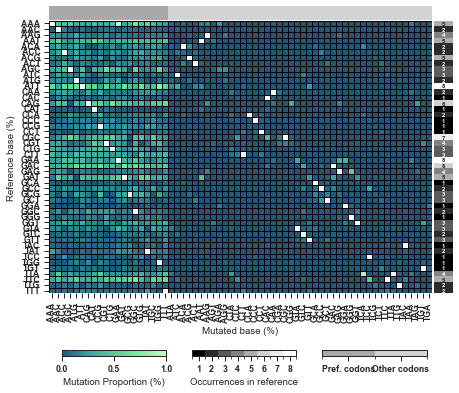

In [10]:
# ======================== PLOTTING MUTAGENIC SPECTRUM WITH ANNOTATIONS ========================

fig, axes = plt.subplots(4, 2, figsize=(wi1, hi*0.7), 
                         gridspec_kw={"height_ratios": [0.05, 1, 0.02, 0.02], "width_ratios": [1, 0.05]})

plt.subplots_adjust(hspace=0.01, wspace=0.01)

# --- Top row: Column annotation heatmap (preferred vs non-preferred codons) ---
sns.heatmap(col_annot_df, cmap=col_cmap, cbar=False, ax=axes[0, 0], xticklabels=False, yticklabels=False)
axes[0, 1].axis("off")

# --- Center: Main mutagenic spectrum heatmap (percentage mutation rates) ---
sns.heatmap(mut_spec_perc_ordered, cmap=custom_cmap, cbar=False, ax=axes[1, 0], xticklabels=True, yticklabels=True, linecolor="black", linewidths=0.5)
axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=90)
axes[1, 0].set_yticklabels(axes[1, 0].get_yticklabels(), rotation=0)
axes[1, 0].set_xlabel('Mutated base (%)')
axes[1, 0].set_ylabel('Reference base (%)')

# --- Right: Row annotation heatmap (codon occurrences in LOV2 region) ---
sns.heatmap(row_annot_df, cmap=row_cmap, cbar=False, ax=axes[1, 1], xticklabels=False, yticklabels=False, annot=True, annot_kws={"size": 6})


# --- Define manual positions for horizontal colorbars below the heatmaps ---
cbar_ax1 = fig.add_axes([0.15, 0.0, 0.2, 0.015])  # Main heatmap
cbar_ax2 = fig.add_axes([0.4, 0.0, 0.2, 0.015])   # Row annotation
cbar_ax3 = fig.add_axes([0.65, 0.0, 0.2, 0.015])  # Column annotation

# --- Colorbar 1: Continuous scale for mutation proportions ---
cbar1 = plt.colorbar(plt.cm.ScalarMappable(cmap=custom_cmap), cax=cbar_ax1, orientation="horizontal")
cbar1.set_label("Mutation Proportion (%)")

# --- Colorbar 2: Discrete scale for row annotation (codon occurrences in LOV2) ---
norm = mcolors.BoundaryNorm(boundaries=np.arange(0.5, np.max(row_annot_df)+1.5, 1), ncolors=row_cmap.N)
cbar2 = mcolorbar.ColorbarBase(cbar_ax2, cmap=row_cmap, norm=norm,
                               orientation="horizontal", ticks=np.arange(1, np.max(row_annot_df)+1,1))
cbar2.set_label("Occurrences in reference")

# --- Colorbar 3: Discrete scale for column annotation (preferred vs non-preferred) ---
norm = mcolors.BoundaryNorm(boundaries=np.arange(0.5, np.max(col_annot_df)+2.5, 1), ncolors=col_cmap.N)
cbar3 = mcolorbar.ColorbarBase(cbar_ax3, cmap=col_cmap, norm=norm,
                               orientation="horizontal", ticks=np.arange(1, np.max(col_annot_df)+1.5,1))
cbar3.set_ticklabels(["Pref. codons", "Other codons"])

axes[2, 0].axis("off")
axes[2, 1].axis("off")
axes[3, 0].axis("off")
axes[3, 1].axis("off")


# plt.savefig(f"final_output/RL8/combined/plots/Codons_mutagenic_spectrum_perc_ordered_Annot.pdf", bbox_inches="tight")
# plt.savefig(f"final_output/RL8/combined/plots/Codons_mutagenic_spectrum_perc_ordered_Annot.png", bbox_inches="tight")
plt.show()

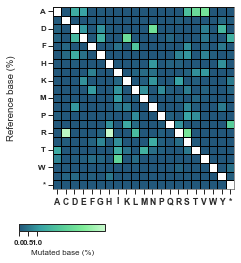

In [11]:
# ======================== PLOT ENRICHMENT AND MUTATIONAL SPECTRUM DATA ========================
# --- Define variant name and data type ---
variant = "DP6" 
dat = "AA"
variant_name = "P01_DP6_LOV2" 

# --- Set paths to input and output folders ---
homedir = f"data/fastq/{variant_name}"
Folder = f"final_output/{variant}/combined/" 

# --- Load amino acid-level mutational spectrum (percentage values) ---
mut_spectrum_AA_perc = pd.read_csv(f"{Folder}/enrichments/{dat}/{variant}_BC1_S1_combined_roiTrue_{dat}_mut_spec.csv", index_col = 0)
# --- Load enrichment matrix (relative mutation enrichment scores) ---
enrichment = pd.read_csv(f"{Folder}/enrichments/{dat}/{variant}_BC1_S1_combined_roiTrue_{dat}_enrichment_relative.csv", index_col = 0)
# --- Define folder to store output plots ---
FigFolder = Folder+ f"/plots/{dat}/"

# --- Identify positions (columns) in enrichment matrix that are entirely NaN ---
empty_cols = enrichment.columns[enrichment.isna().all()]

# --- Replace all NaN values in the enrichment matrix with 0 (required for calculations) ---
enrichment.fillna(0, inplace=True)
# --- Set reference sequence based on data type (AA or DNA) ---
ref = translate_dna2aa(LOV2_gene) if dat != "DNA" else LOV2_gene

# --- Calculate amino acid-level mutational spectrum from enrichment data ---
#     Returns both absolute counts and percentage distribution of mutations
mut_spectrum_AA,mut_spectrum_AA_perc = calc_mut_spectrum_from_enrichment(enrichment, ref_seq=ref, data_type=dat)

# --- Plot mutational spectrum as a heatmap (AA × AA, percentage-based) ---
plot_mutation_spectrum(mut_spectrum_AA_perc, data_type=dat, colormap=custom_cmap)

In [12]:
# ======================== FILTER LOV2 REFERENCE SEQUENCE ========================
LOV2_AAs_all = "LATTLERIEKNFVITDPRLPDNPIIFASDSFLQLTEYSREEILGRNCRFLQGPETDRATVRKIRDAIDNQTEVTVQLINYTKSGKKFWNLFHLQPMRDQKGDVQYFIGVQLDGTEHVRDAAEREGVMLIKKTAENIDEAAK"
LOV2_AAs = []
# --- Iterate through each amino acid and exclude positions listed in `empty_cols` ---
for idx,LOV_aa in enumerate(LOV2_AAs_all):
    if str(idx) not in empty_cols: 
        LOV2_AAs.append(LOV_aa)
# --- Join the filtered amino acids back into a continuous sequence string ---
LOV2_AAs = "".join(LOV2_AAs)


# --- Count occurrences of each amino acid in the filtered LOV2 reference sequence ---
counter_LOV = Counter(LOV2_AAs)
# --- Ensure all amino acids in the mutational spectrum are included in the counter ---
for codon in mut_spectrum_AA_perc.index:
    if codon not in counter_LOV:
        counter_LOV[codon] = 0
# --- Sort dictionary alphabetically by amino acid, placing '*' (stop codon) last ---
counter_LOV = dict(sorted(counter_LOV.items(), key = lambda x: x[0] if x[0] != "*" else "Z"))

# --- Extract the ordered list of amino acid counts for row annotation ---
row_annot = list(counter_LOV.values())



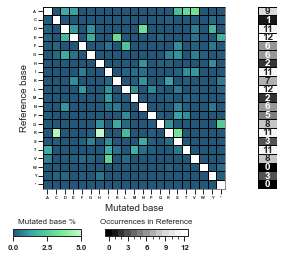

In [ ]:
# ======================== PLOT MUTAGENIC SPECTRUM WITH ROW ANNOTATION ========================

fig, axes = plt.subplots(1, 2, figsize=(4.76, 6.69291/2), gridspec_kw={"width_ratios": [4, 0.3]})
fig.subplots_adjust(wspace=0.01)

# --- Plot amino acid mutational spectrum (percentage values) ---
sns.heatmap(mut_spectrum_AA_perc, annot=False, linecolor = "black", cmap = custom_cmap,  xticklabels=True,yticklabels = True, ax=axes[0], cbar = False, linewidths=.5, square=True, vmin=0, vmax=5)

# --- Plot row annotation (AA frequency in LOV2 reference) ---
sns.heatmap(pd.DataFrame(row_annot), cmap=row_cmap, annot=True, linewidths=.5,linecolor="black" ,
            xticklabels=False, yticklabels=True, ax=axes[1], cbar=False)

# --- Clean up annotation subplot appearance ---
axes[1].set_yticks([]) 
axes[1].set_ylabel("") 

# --- Labels and axis formatting ---
axes[0].set_xlabel('Mutated base')
axes[0].set_ylabel('Reference base')
axes[0].set_yticklabels(axes[0].get_yticklabels(), rotation=0)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0, fontsize=4)
axes[0].set_yticklabels(axes[0].get_yticklabels(), rotation=0, fontsize=4)
axes[0].tick_params(axis='x', pad=2)
axes[0].tick_params(axis='y', pad=2)

# --- Add horizontal colorbar for mutation percentages ---
cbar_ax = fig.add_axes([0.13, -0.07, 0.2, 0.025])
cbar = fig.colorbar(axes[0].collections[0], cax=cbar_ax, orientation="horizontal", extend='neither')
cbar.ax.set_title("Mutated base %", fontsize=8, pad=6)
cbar.ax.tick_params(labelsize=8)


# --- Define position and appearance of second (discrete) colorbar ---
cbar_ax2 = fig.add_axes([0.4, -0.07, 0.24, 0.025])

# --- Define tick ranges for even and odd positions ---
max_tick = int(np.max(row_annot))
even_ticks = np.arange(0, max_tick + 1, 3)
odd_ticks = [1,2,4,5,7,8, 10, 11]

# --- Normalize row annotation color scale ---
norm = mcolors.BoundaryNorm(boundaries=np.arange(-0.5, max_tick + 1.5, 1), ncolors=row_cmap.N)

# --- Create second colorbar for occurrence annotations ---
cbar2 = mcolorbar.ColorbarBase(
    cbar_ax2, cmap=row_cmap, norm=norm,
    orientation="horizontal", ticks=even_ticks,
    spacing='proportional'
)

cbar2.ax.xaxis.set_major_locator(mticker.FixedLocator(even_ticks)) 
cbar2.ax.xaxis.set_minor_locator(mticker.FixedLocator(odd_ticks)) 
cbar2.ax.tick_params(which='minor', length=2.5) 
cbar2.ax.set_title("Occurrences in Reference", fontsize=8, pad=6)
cbar2.ax.tick_params(labelsize=8)

# --- Ensure main heatmap box edges are visible and styled ---
for _, spine in axes[0].spines.items():
    spine.set_visible(True)
    spine.set_linewidth(.5) 
    spine.set_color('#231F20')    


plt.savefig(f"{FigFolder}/AAs_mutagenic_spectrum_roi_perc_ordered_Annot.pdf", bbox_inches="tight")
plt.savefig(f"{FigFolder}/AAs_mutagenic_spectrum_roi_perc_ordered_Annot.png", bbox_inches="tight")
plt.show()



